# Test data

In [1]:
import numpy as np
from scipy import linalg as LA
X = np.array([
        [0.387,4878, 5.42],
        [0.723,12104,5.25],
        [1,12756,5.52],
        [1.524,6787,3.94],
    ])

# Non-Iinear Iterative Partial Least-Squares (NIPALS) algorithm

## ALGORITHM

Steps to compute PCA using NIPALS algorithm

* Step 1: Initialize an arbitrary column vector $\mathbf{t}_{a}$ either randomly or by just copying any column of X. 
* Step 2: Take very column of $X$, $X_{k}$ and regress it onto the $\mathbf{t}_{a}$ vector and store the regression coefficeints as $\mathbf{p}_{ka}$. (Note: This simply means performing an ordinary least squares regression ($y=mx$) with $x=t_{a}$ and $y=X_{k}$ with $m=(\mathbf{x}'\mathbf{x})^{-1}\mathbf{x}'\mathbf{y}$). In the current notation we get 
$$p_{ka}=\frac{\mathbf{t}_{a}^{'}\mathbf{X}_{k}}{\mathbf{t}_{a}^{'}\mathbf{t}_{a}}$$
Repeat it for each of the columns of $X$ to get the entire vector $\mathbf{p}_{k}$. This is shown in the illustration
above where each column from $X$ is regressed, one at a time, on $\mathbf{t}_{a}$, to calculate the loading entry, $\mathbf{𝑝}_{ka}$ In
practice we don’t do this one column at time; we can regress all columns in $X$ in go: $$\mathbf{p}_{a}^{'}=\frac{1}{\mathbf{t}_{a}^{'}\mathbf{t}_{a}}.\mathbf{t}_{a}^{'}\mathbf{X}_{a}$$  where $\mathbf{t}_{a}$ is an $N \times 1$ column vector, and $\mathbf{X}_{a}$ us an $N \times K$ matrix.
* The loading vector $\mathbf{p}_{a}^{'}$ won’t have unit length (magnitude) yet. So we simply rescale it to have
magnitude of 1.0: $$\mathbf{p}_{a}^{'}=\frac{1}{\sqrt{\mathbf{p}_{a}^{'}\mathbf{p}_{a}}.\mathbf{p}_{a}^{'}}$$
* Step 4: Regress every row in $X$ onto this normalized loadings vector. As illustrated below, in our linear regression the rows in X are our y-variable each time, while the loadings vector is our x-variable. The regression coefficient becomes the score value for that $𝑖^{th}$ row:
$$p_{i,a}=\frac{\mathbf{x}_{i}^{'}\mathbf{p}_{a}}{\mathbf{p}_{a}^{'}\mathbf{p}_{a}}$$
where $x_{i}^{'}$ is a $K \times 1$ column vector. We can combine these $N$ separate least-squares models and
calculate them in one go to get the entire vector, 
$$\mathbf{t}_{a}^{'}=\frac{1}{\mathbf{p}_{a}^{'}\mathbf{p}_{a}}\mathbf{X}\mathbf{p}_{a}^{'}$$  where $p_{a}$ is a $K \times 1$ column vector.
* Step 5: Continue looping over steps 2,3,4 until the change in vector $t_{a}$ is below a chosen tolerance
* Step 6: On convergence, the score vector and the loading vectors, $\mathbf{t}_{a}$ and $\mathbf{p}_{a}$ are stored as the $a^{th}$ column in matrix $\mathbf{T}$ and $\mathbf{P}$. We then deflate the $\mathbf{X}$ matrix. This crucial step removes the variability captured in this component ($t_{a}$ and $p_{a}$) from $\mathbf{X}$:
$$E_{a}=X_{a}-t_{a}p_{a}^{'}$$
$$X_{a+1} = E_{a}$$ 

For the first component, $X_{a}$ is just the preprocessed raw data. So we can see that the second component is actually calculated on the residuals $E_{1}$, obtained after extracting the first component. This is called deflation, and nicely shows why each component is orthogonal to the others. Each subsequent component is only seeing variation remaining after removing all the others; there is no possibility that two components can explain the same type of variability. After deflation we go back to step 1 and repeat the entire process for the next component. 

## IMPLEMENTATION IN PYTHON

In [2]:
def PCA(X,no_components):
    tol = 0.0000001
    it=1000
    obsCount,varCount = X.shape
    Xa = X - np.mean(X, axis = 0) 
    #Xh = X-np.tile(np.mean(X,axis=0).reshape(-1,1).T, obsCount).reshape(4,3)
    T = np.zeros((obsCount,no_components))
    P = np.zeros((varCount,no_components))
    pcvar = np.zeros((varCount,1))
    varTotal = np.sum(np.var(Xa,axis=0,ddof=1))
    currVar = varTotal
    nr=0
    for h in range(no_components):
        th = Xa[:,0].reshape(-1,1)
        ende = False
        while ende != True:
            nr = nr + 1
            ph = np.dot(Xa.T,th)/np.dot(th.T,th)
            ph = ph /np.linalg.norm(ph)
            thnew = np.dot(Xa,ph)/np.dot(ph.T,ph)
            prec = np.dot((thnew-th).T,(thnew-th))
            th = thnew
            if prec <= (tol*tol):
                ende = True
            elif it <=nr:
                ende = True
                print("Iternation stops without convergence")
        Ea = Xa - np.dot(th,ph.T)
        Xa = Ea    
        T[:,h] = th.flatten()
        P[:,h] = ph.flatten()
        oldVar = currVar
        currVar = np.sum(np.var(Xa,axis=0,ddof=1))
        pcvar[h] = (oldVar - currVar) / varTotal
        nr = 0
    return T,P,pcvar      

## Advantages of the NIPALS algorithm
* The NIPALS algorithm computes one component at a time. The first component computed is
equivalent to the t1 and p1 vectors that would have been found from an eigenvalue or singular value
decomposition.
* The algorithm can handle missing data in X.
* The algorithm always converges, but the convergence can sometimes be slow.
* It is also known as the Power algorithm to calculate eigenvectors and eigenvalues.
* It works well for very large data sets.
* It is used by most software packages, especially those that handle missing data.
* Of interest: it is well known that Google used this algorithm for the early versions of their search engine, called PageRank148.

In [3]:
no_components=3
T,P,pcvar = PCA(X,no_components)

In [4]:
T

array([[-4.25324997e+03, -8.41288672e-01,  8.37859036e-03],
       [ 2.97275001e+03, -1.25977272e-01, -1.82476780e-01],
       [ 3.62475003e+03, -1.56843494e-01,  1.65224286e-01],
       [-2.34425007e+03,  1.12410944e+00,  8.87390330e-03]])

In [5]:
P

array([[ 1.21901390e-05,  5.66460728e-01,  8.24088735e-01],
       [ 9.99999997e-01,  5.32639787e-05, -5.14047689e-05],
       [ 7.30130279e-05, -8.24088733e-01,  5.66460726e-01]])

In [6]:
pcvar

array([[9.99999955e-01],
       [4.41567976e-08],
       [1.33326424e-09]])

TypeError: rand_in_ellipse() missing 1 required positional argument: 'a'

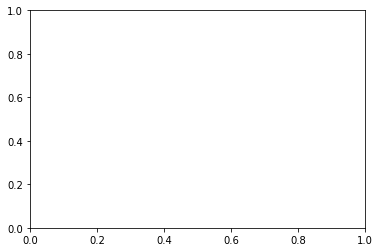

In [3]:
import numpy as np
pi = np.pi
def rand_in_ellipse(a, b=1, offset=0):
    angle = 2*pi*random() - offset
    x = a * random() * np.cos(angle)
    y = b * random() * np.sin(angle)
    return np.array((x,y))

import matplotlib.pyplot as plt
fig = plt.figure()

ax = fig.add_subplot(111)


sample = np.array([rand_in_ellipse() for i in np.arange(10000)])
ax.scatter(sample[:,0], sample[:,1])

plt.show() # Figure attached
